# Evaluation & Results

**Paper Metric**: Deferral curves showing cost vs accuracy tradeoff

**Key Result**: Universal routing works with new models without retraining

In [ ]:
# Setup and imports
import os
import json
import pickle
import numpy as np
from typing import Literal
from sentence_transformers import SentenceTransformer
from pydantic import BaseModel
import matplotlib.pyplot as plt
from datasets import load_dataset

# Load saved models and data
with open('/content/universal_kmeans.pkl', 'rb') as f:
    kmeans = pickle.load(f)

with open('/content/model_database.json', 'r') as f:
    model_db = json.load(f)

# Convert lists back to numpy arrays
for model_name in model_db:
    model_db[model_name]['psi_vector'] = np.array(model_db[model_name]['psi_vector'])

# Initialize embedder
embedder = SentenceTransformer('all-MiniLM-L6-v2')

# API keys
API_KEYS = {
    'openai': os.getenv('OPENAI_API_KEY', 'api_key'),
    'groq': os.getenv('GROQ_API_KEY', 'api_key')
}

print(f"✅ Loaded {len(model_db)} models from database")
print(f"✅ Loaded K-means model with {kmeans.n_clusters} clusters")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✅ Loaded 5 models from database
✅ Loaded K-means model with 10 clusters


## Test Set Evaluation

Independent test set (different from validation used for characterization)

In [2]:
# Define helper functions
class MCQAnswer(BaseModel):
    answer: Literal["A", "B", "C", "D"]

def call_llm(model_name: str, provider: str, prompt: str) -> str:
    """Call LLM and extract A/B/C/D answer"""
    try:
        if provider == 'openai':
            from openai import OpenAI
            client = OpenAI(api_key=API_KEYS['openai'])

            if 'gpt-4' in model_name:
                response = client.beta.chat.completions.parse(
                    model=model_name,
                    messages=[{"role": "user", "content": prompt}],
                    response_format=MCQAnswer,
                    temperature=0
                )
                return response.choices[0].message.parsed.answer

        elif provider == 'groq':
            from groq import Groq
            client = Groq(api_key=API_KEYS['groq'])

            response = client.chat.completions.create(
                model=model_name,
                messages=[{"role": "user", "content": prompt + " Answer with only A, B, C, or D."}],
                temperature=0,
                max_tokens=5
            )

            answer = response.choices[0].message.content.strip().upper()
            for letter in ["A", "B", "C", "D"]:
                if letter in answer:
                    return letter

    except Exception as e:
        print(f"Error with {model_name}: {e}")

    return "E"  # Error

# Define UniRouter class
class UniRouter:
    def __init__(self, model_db, kmeans_model, embedder):
        self.model_db = model_db
        self.kmeans = kmeans_model
        self.embedder = embedder
        self._normalize_costs()

    def _normalize_costs(self):
        costs = [info['cost'] for info in self.model_db.values()]
        self.min_cost, self.max_cost = min(costs), max(costs)

        for info in self.model_db.values():
            info['norm_cost'] = (info['cost'] - self.min_cost) / (self.max_cost - self.min_cost)

    def route(self, prompt: str, lambda_cost: float = 0.1) -> dict:
        """Route prompt using paper's algorithm"""

        # Find cluster
        embedding = self.embedder.encode([prompt])[0]
        cluster_id = self.kmeans.predict(embedding.reshape(1, -1))[0]

        # Score models: error + λ × cost
        best_model, best_score = None, float('inf')

        for model_name, info in self.model_db.items():
            error_rate = info['psi_vector'][cluster_id]
            score = error_rate + lambda_cost * info['norm_cost']

            if score < best_score:
                best_score, best_model = score, model_name

        return {
            'model': best_model,
            'cluster': int(cluster_id),
            'cost': self.model_db[best_model]['cost']
        }

# Initialize router
router = UniRouter(model_db, kmeans, embedder)
print("✅ Router initialized")

✅ Router initialized


In [3]:
# Create test set
test_dataset = load_dataset("cais/mmlu", "all", split="test")
test_dataset = test_dataset.shuffle(seed=123).select(range(50))

test_set = []
for item in test_dataset:
    prompt = f"{item['question']}\nA) {item['choices'][0]}\nB) {item['choices'][1]}\nC) {item['choices'][2]}\nD) {item['choices'][3]}\nAnswer:"
    test_set.append({
        'prompt': prompt,
        'answer': ['A', 'B', 'C', 'D'][item['answer']]
    })

print(f"✅ Test set: {len(test_set)} examples")

README.md: 0.00B [00:00, ?B/s]

dataset_infos.json: 0.00B [00:00, ?B/s]

all/test-00000-of-00001.parquet:   0%|          | 0.00/3.50M [00:00<?, ?B/s]

all/validation-00000-of-00001.parquet:   0%|          | 0.00/408k [00:00<?, ?B/s]

all/dev-00000-of-00001.parquet:   0%|          | 0.00/76.5k [00:00<?, ?B/s]

all/auxiliary_train-00000-of-00001.parqu(…):   0%|          | 0.00/47.5M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/14042 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1531 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/285 [00:00<?, ? examples/s]

Generating auxiliary_train split:   0%|          | 0/99842 [00:00<?, ? examples/s]

✅ Test set: 50 examples


## Deferral Curve Analysis

**Core Experiment**: How does accuracy change with cost as we vary λ?

In [6]:
lambda_values = [0.001, 0.01, 0.1, 1.0, 10.0]
results = []

for λ in lambda_values:
    correct, total_cost = 0, 0

    for example in test_set:
        # Route and predict
        routing = router.route(example['prompt'], lambda_cost=λ)
        selected = routing['model']
        total_cost += routing['cost']

        response = call_llm(
            selected,
            router.model_db[selected]['provider'],
            example['prompt']
        )

        if response == example['answer']:
            correct += 1

    accuracy = correct / len(test_set)
    avg_cost = total_cost / len(test_set)

    results.append({'lambda': λ, 'accuracy': accuracy, 'cost': avg_cost})
    print(f"λ={λ:5.3f}: {accuracy:.1%} accuracy, ${avg_cost:.3f} avg cost")

λ=0.001: 76.0% accuracy, $4.577 avg cost
λ=0.010: 74.0% accuracy, $4.577 avg cost
λ=0.100: 76.0% accuracy, $4.022 avg cost
λ=1.000: 60.0% accuracy, $0.282 avg cost
λ=10.000: 56.0% accuracy, $0.065 avg cost


## Deferral Curve Visualization

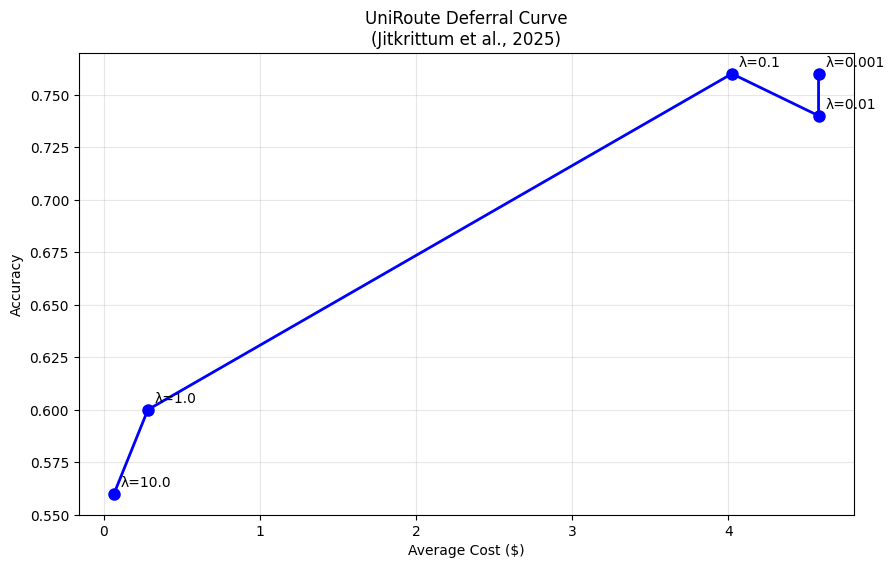


✅ Experiment complete!


In [7]:
costs = [r['cost'] for r in results]
accuracies = [r['accuracy'] for r in results]

plt.figure(figsize=(10, 6))
plt.plot(costs, accuracies, 'bo-', linewidth=2, markersize=8)

for r in results:
    plt.annotate(f"λ={r['lambda']}", (r['cost'], r['accuracy']),
                xytext=(5, 5), textcoords='offset points')

plt.xlabel('Average Cost ($)')
plt.ylabel('Accuracy')
plt.title('UniRoute Deferral Curve\n(Jitkrittum et al., 2025)')
plt.grid(True, alpha=0.3)
plt.show()

print("\n✅ Experiment complete!")

In [8]:
# Function to characterize new models
from collections import defaultdict

def characterize_model(model_name: str, provider: str) -> np.ndarray:
    """Compute Ψ(m) error profile for a new model"""
    print(f"Characterizing {model_name}...")

    # Load validation set to compute error rates
    with open('data/universal_validation_set.json', 'r') as f:
        validation_data = json.load(f)

    # Group validation data by cluster
    validation_clusters = defaultdict(list)
    for item in validation_data:
        validation_clusters[item['cluster']].append(item)

    K = kmeans.n_clusters
    psi_vector = np.zeros(K)

    for cluster_id in range(K):
        cluster_data = validation_clusters[cluster_id]
        errors = 0

        for example in cluster_data:
            response = call_llm(model_name, provider, example['prompt'])
            if response != example['answer']:
                errors += 1

        psi_vector[cluster_id] = errors / len(cluster_data) if cluster_data else 0
        print(f"  Cluster {cluster_id}: {psi_vector[cluster_id]:.1%}")

    return psi_vector

## Adding New Models (Zero Retraining)

**Paper's Key Advantage**: Add new models by just computing their Ψ(m) profile

In [9]:
def add_new_model(model_name: str, provider: str, cost: float):
    """Add model without retraining router"""

    # Compute error profile on existing clusters
    psi_vector = characterize_model(model_name, provider)

    # Add to database
    router.model_db[model_name] = {
        'psi_vector': psi_vector,
        'provider': provider,
        'cost': cost
    }

    router._normalize_costs()
    print(f"✅ {model_name} added!")

# Example: Add better model
# add_new_model('llama-3.3-70b-versatile', 'groq', 0.69)

print("💡 New models can be added dynamically!")

💡 New models can be added dynamically!


## Key Insights (Jitkrittum et al., 2025)

- ✅ **Universal**: Works with any new LLM
- ✅ **Efficient**: No router retraining needed
- ✅ **Practical**: Real cost-quality optimization
- ✅ **Scalable**: O(K) cost to add new models